In [9]:
import sys, os

# if your notebook lives in LAB3/notebooks and src/ is in LAB3/src,
# this will add the LAB3 folder into Python’s search path:
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [10]:
import pandas as pd
import random
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
import tqdm as notebook_tqdm
from src.metrics import print_error_rate_total_y_cat

In [11]:
# Cargar el dataset
df = pd.read_csv('../data/ventas_featurev4.csv', sep=',')

In [12]:
SEED = 26461180
random.seed(SEED)
np.random.seed(SEED)

# Convertir 'periodo' de fecha a entero tipo YYYYMM
df["periodo"] = pd.to_datetime(df["periodo"])
df["periodo"] = df["periodo"].dt.strftime("%Y%m").astype(int)

# Convierte todas las columnas object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')
    
df = df.sort_values(['product_id','periodo'])

# Convertir todas las columnas float64 a float16 en sell_in_featured1
float64_cols = df.select_dtypes(include=['float64']).columns
df[float64_cols] = df[float64_cols].astype('float16')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 97 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   periodo                    int32   
 1   customer_id                int64   
 2   product_id                 int64   
 3   plan_precios_cuidados      float16 
 4   tn                         float16 
 5   cust_request_qty           float16 
 6   cust_request_tn            float16 
 7   cat1                       category
 8   cat2                       category
 9   cat3                       category
 10  brand                      category
 11  sku_size                   int64   
 12  descripcion                category
 13  productos_estrella         int64   
 14  mes                        int64   
 15  catastrofe                 int64   
 16  cliente_estrella           int64   
 17  prod_cust                  category
 18  tn_lag_1                   float16 
 19  tn_lag_2           

In [13]:
# 3) Define target and features
label_col = 'tn'
y = df[label_col].astype('float32')
X = df.drop(columns=[label_col])
X = X.drop(columns=['descripcion','prod_cust'])


In [14]:
from sklearn.model_selection import TimeSeriesSplit

test_mask = df['periodo'] == 201912
X_tv, y_tv = X[~test_mask], y[~test_mask]
X_test, y_test = X[test_mask], y[test_mask]

# time-series CV on train+val
tscv = TimeSeriesSplit(
    n_splits=3,
    max_train_size=None,   # grows the training window
    test_size=1            # one period per fold
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tv)):
    print(f"Fold {fold} → train: {df.periodo.iloc[train_idx].min()}–"
          f"{df.periodo.iloc[train_idx].max()},  val: "
          f"{df.periodo.iloc[val_idx].unique()}")
    X_train, X_val = X_tv.iloc[train_idx], X_tv.iloc[val_idx]
    y_train, y_val = y_tv.iloc[train_idx], y_tv.iloc[val_idx]
    


Fold 0 → train: 201701–201912,  val: [201712]
Fold 1 → train: 201701–201912,  val: [201712]
Fold 2 → train: 201701–201912,  val: [201712]


In [15]:
def objective(trial):
    # fixed estimators; early stopping handled in .fit()
    params = {
        'n_estimators': 1_000,
        'objective':   'regression',
        'random_state': SEED,
        'boosting_type': 'gbdt',
        'num_leaves':    trial.suggest_int('num_leaves', 31, 512),
        'max_depth':     trial.suggest_int('max_depth', 6, 30),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'feature_fraction':  trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=5)
        ]
    )
    preds = model.predict(X_val)
    mse  = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize', study_name='lgbm_tn_2')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best RMSE on 201911:", study.best_value)
print("Best params:", study.best_params)

# 7) Retrain on train+val and forecast Feb-2020
best_params = study.best_params.copy()
best_params.update({
    'n_estimators': study.best_trial.user_attrs.get('n_estimators', 1_000),
    'objective': 'regression',
    'random_state': SEED
})

[I 2025-07-01 19:17:44,450] A new study created in memory with name: lgbm_tn_2
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8999528924358234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999528924358234
[LightGBM] [Warning] lambda_l1 is set=9.372586893107163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.372586893107163e-07
[LightGBM] [Warning] lambda_l2 is set=1.5420434235982474e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5420434235982474e-08
[LightGBM] [Warning] bagging_fraction is set=0.6786154096198447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6786154096198447
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8999528924358234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999528924358234
[LightGBM] [Warning] lambda_l1 is set=9.372586893107163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.372586893107163e-07
[LightGBM] [Warni

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000001B97BD4DCF0>
Traceback (most recent call last):
  File "c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\lightgbm\basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Auto-choosing row-wise multi-threading, the overhead of testing was 2.432825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19664
[LightGBM] [Info] Number of data points in the train set: 16298099, number of used features: 94
[LightGBM] [Warning] feature_fraction is set=0.8999528924358234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999528924358234
[LightGBM] [Warning] lambda_l1 is set=9.372586893107163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.372586893107163e-07
[LightGBM] [Warning] lambda_l2 is set=1.5420434235982474e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5420434235982474e-08
[LightGBM] [Warning] bagging_fraction is set=0.6786154096198447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6786154096198447
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. C

In [12]:
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    pd.concat([X_train, X_val]),
    pd.concat([y_train, y_val]),
    eval_metric='rmse'
)

preds_202002 = final_model.predict(X_test)
results = df.loc[test_mask, ['product_id','periodo']].copy()
results['pred_tn_202002'] = preds_202002

print(results.head())

# results.to_csv('../data/lgbm_forecast_202002_per_product.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.956171264589964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956171264589964
[LightGBM] [Warning] lambda_l1 is set=0.00022935117286783794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022935117286783794
[LightGBM] [Warning] lambda_l2 is set=4.7040833615196834e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7040833615196834e-08
[LightGBM] [Warning] bagging_fraction is set=0.5421463876423206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5421463876423206
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.956171264589964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956171264589964
[LightGBM] [Warning] lambda_l1 is set=0.00022935117286783794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022935117286783794
[LightGBM] [Warni

In [ ]:
results['forecast_period'] = (
    pd.to_datetime(results['periodo'].astype(str), format='%Y%m')
      .add(pd.DateOffset(months=2))
      .dt.strftime('%Y%m')
      .astype(int)
)

prod_forecast = (
    results
      .groupby(['product_id','forecast_period'], as_index=False)
      ['pred_tn_202002']
      .sum()
      .rename(columns={'pred_tn_202002':'agg_pred_tn_202002'})
)

max_period = df['periodo'].max()  # should be 201912
# get the three prior periods dynamically
ts_max = pd.to_datetime(str(max_period), format='%Y%m')
last3 = [
    (ts_max - pd.DateOffset(months=i)).strftime('%Y%m')
    for i in (1,2,3)
]
last3 = [int(x) for x in last3]  # [201911,201910,201909]

hist_mean = (
    df[df['periodo'].isin(last3)]
      .groupby('product_id')['tn']
      .mean()
      .reset_index()
      .rename(columns={'tn':'fallback_mean_last3'})
)

prod_forecast = prod_forecast.merge(hist_mean, on='product_id', how='left')
prod_forecast['final_forecast'] = prod_forecast.apply(
    lambda r: r['fallback_mean_last3']
              if r['agg_pred_tn_202002'] < 0
              else r['agg_pred_tn_202002'],
    axis=1
)

final = prod_forecast[[
    'product_id',
    'forecast_period',
    'final_forecast'
]].rename(columns={'final_forecast':'pred_tn_202002'})

output = (
    final
      .loc[:, ['product_id', 'pred_tn_202002']]
      .rename(columns={'pred_tn_202002': 'tn'})
)



print(output.head())

# 7) Persist to CSV
output.to_csv('../data/lgbm_forecast_202002_per_productv6.csv', index=False)

   product_id           tn
0       20001  1444.044956
1       20002  1097.350068
2       20003  1053.255103
3       20004   767.045802
4       20005   598.838563


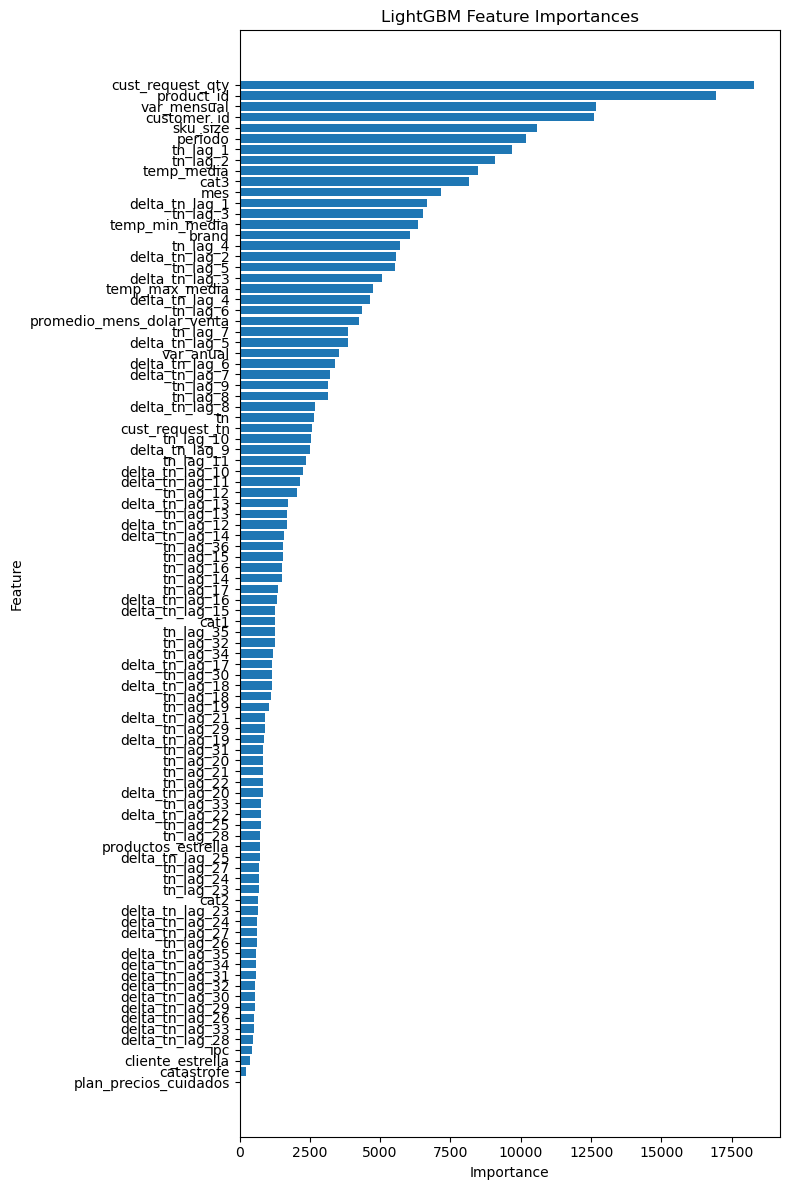

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances and feature names
importances = final_model.feature_importances_
feature_names = X.columns.tolist()

# Sort by importance
indices = np.argsort(importances)
sorted_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 12))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

In [23]:
sorted_importances

array([   50,   215,   364,   440,   487,   515,   522,   536,   551,
         552,   577,   582,   601,   617,   621,   629,   665,   668,
         676,   687,   688,   717,   717,   723,   756,   757,   774,
         819,   831,   832,   832,   849,   886,   893,   914,  1038,
        1112,  1138,  1151,  1157,  1188,  1245,  1246,  1265,  1266,
        1336,  1351,  1506,  1518,  1540,  1546,  1590,  1697,  1701,
        1738,  2026,  2152,  2253,  2362,  2507,  2547,  2573,  2660,
        2679,  3133,  3151,  3219,  3385,  3527,  3856,  3863,  4232,
        4344,  4632,  4730,  5080,  5523,  5578,  5713,  6063,  6342,
        6535,  6674,  7153,  8146,  8466,  9070,  9671, 10177, 10584,
       12593, 12689, 16941, 18299])

In [33]:
dfv4 = df.copy()

roll = dfv4.groupby('product_id')['tn'].rolling(3, min_periods=1)

dfv4['roll3_mean']   = roll.mean().reset_index(0,drop=True)
dfv4['roll3_std']    = roll.std().reset_index(0,drop=True)
dfv4['roll3_sum']    = roll.sum().reset_index(0,drop=True)
dfv4['roll3_median'] = roll.median().reset_index(0,drop=True)

# Bollinger bands
dfv4['bb_upper'] = dfv4['roll3_mean'] + 2 * dfv4['roll3_std']
dfv4['bb_lower'] = dfv4['roll3_mean'] - 2 * dfv4['roll3_std']

# ratio to rolling mean (“momentum” signal)
dfv4['tn_to_roll3mean'] = dfv4['tn'] / (dfv4['roll3_mean'] + 1e-6)

# cyclical month encoding
dfv4['month_sin'] = np.sin(2 * np.pi * dfv4['mes'] / 12)
dfv4['month_cos'] = np.cos(2 * np.pi * dfv4['mes'] / 12)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

key_cols = ['periodo','product_id','customer_id','tn_mas_2','tn']

threshold = feat_imp['importance'].quantile(0.25)
keep_orig = feat_imp.loc[feat_imp.importance >= threshold, 'feature'].tolist()

new_features = [
    'roll3_mean','roll3_std','roll3_sum','roll3_median',
    'bb_upper','bb_lower','tn_to_roll3mean',
    'month_sin','month_cos'
]

keep_orig = [f for f in keep_orig if f not in key_cols]

df_new = dfv4[key_cols + keep_orig + new_features].copy()

print("Kept original features:", keep_orig)
print("New features added:", new_features)
print("New dataset shape:", df_new.shape)

# 6) (Optional) Save to disk
df_new.to_parquet('../data/ventas_feature_engineered.parquet', index=False)

Kept original features: ['cust_request_qty', 'cust_request_tn', 'cat1', 'cat3', 'brand', 'sku_size', 'mes', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_25', 'tn_lag_29', 'tn_lag_30', 'tn_lag_31', 'tn_lag_32', 'tn_lag_33', 'tn_lag_34', 'tn_lag_35', 'tn_lag_36', 'delta_tn_lag_1', 'delta_tn_lag_2', 'delta_tn_lag_3', 'delta_tn_lag_4', 'delta_tn_lag_5', 'delta_tn_lag_6', 'delta_tn_lag_7', 'delta_tn_lag_8', 'delta_tn_lag_9', 'delta_tn_lag_10', 'delta_tn_lag_11', 'delta_tn_lag_12', 'delta_tn_lag_13', 'delta_tn_lag_14', 'delta_tn_lag_15', 'delta_tn_lag_16', 'delta_tn_lag_17', 'delta_tn_lag_18', 'delta_tn_lag_19', 'delta_tn_lag_20', 'delta_tn_lag_21', 'delta_tn_lag_22', 'var_mensual', 'var_anual', 'promedio_mens_dolar_venta', 'temp_media', 'temp_max_media', 

In [34]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 80 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   periodo                    int32   
 1   product_id                 int64   
 2   customer_id                int64   
 3   tn_mas_2                   float16 
 4   tn                         float16 
 5   cust_request_qty           float16 
 6   cust_request_tn            float16 
 7   cat1                       category
 8   cat3                       category
 9   brand                      category
 10  sku_size                   int64   
 11  mes                        int64   
 12  tn_lag_1                   float16 
 13  tn_lag_2                   float16 
 14  tn_lag_3                   float16 
 15  tn_lag_4                   float16 
 16  tn_lag_5                   float16 
 17  tn_lag_6                   float16 
 18  tn_lag_7                   float16 
 19  tn_lag_8           

In [35]:
df_new.head()

,periodo,product_id,customer_id,tn_mas_2,tn,cust_request_qty,cust_request_tn,cat1,cat3,brand,...,temp_min_media,roll3_mean,roll3_std,roll3_sum,roll3_median,bb_upper,bb_lower,tn_to_roll3mean,month_sin,month_cos
0,201701,20001,10001,143.500000,99.437500,11.0,99.437500,HC,Liquido,ARIEL,...,20.90625,99.437500,NaN,99.437500,99.437500,NaN,NaN,1.000000,0.5,0.866025
1,201701,20001,10002,184.750000,35.718750,17.0,38.687500,HC,Liquido,ARIEL,...,20.90625,67.578125,45.055960,135.156250,67.578125,157.690045,-22.533795,0.528555,0.5,0.866025
2,201701,20001,10003,19.078125,143.500000,17.0,143.500000,HC,Liquido,ARIEL,...,20.90625,92.885417,54.188530,278.656250,99.437500,201.262477,-15.491644,1.544914,0.5,0.866025
3,201701,20001,10004,43.843750,184.750000,9.0,184.750000,HC,Liquido,ARIEL,...,20.90625,121.322917,76.950930,363.968750,143.500000,275.224777,-32.578943,1.522796,0.5,0.866025
4,201701,20001,10005,65.125000,19.078125,23.0,19.078125,HC,Liquido,ARIEL,...,20.90625,115.776042,86.245324,347.328125,143.500000,288.266690,-56.714607,0.164785,0.5,0.866025


In [37]:
# 3) Define target and features
label_col = 'tn_mas_2'
y = df_new[label_col].astype('float32')
X = df_new.drop(columns=[label_col])
#X = X.drop(columns=['descripcion','prod_cust'])

In [38]:
from sklearn.model_selection import TimeSeriesSplit

test_mask = df_new['periodo'] == 201912
X_tv, y_tv = X[~test_mask], y[~test_mask]
X_test, y_test = X[test_mask], y[test_mask]

# time-series CV on train+val
tscv = TimeSeriesSplit(
    n_splits=3,
    max_train_size=None,   # grows the training window
    test_size=1            # one period per fold
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tv)):
    print(f"Fold {fold} → train: {df_new.periodo.iloc[train_idx].min()}–"
          f"{df_new.periodo.iloc[train_idx].max()},  val: "
          f"{df_new.periodo.iloc[val_idx].unique()}")
    X_train, X_val = X_tv.iloc[train_idx], X_tv.iloc[val_idx]
    y_train, y_val = y_tv.iloc[train_idx], y_tv.iloc[val_idx]

Fold 0 → train: 201701–201912,  val: [201712]
Fold 1 → train: 201701–201912,  val: [201712]
Fold 2 → train: 201701–201912,  val: [201712]


In [39]:
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    pd.concat([X_train, X_val]),
    pd.concat([y_train, y_val]),
    eval_metric='rmse'
)

preds_202002 = final_model.predict(X_test)
results = df_new.loc[test_mask, ['product_id','periodo']].copy()
results['pred_tn_202002'] = preds_202002

print(results.head())

[LightGBM] [Warning] feature_fraction is set=0.956171264589964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956171264589964
[LightGBM] [Warning] lambda_l1 is set=0.00022935117286783794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022935117286783794
[LightGBM] [Warning] lambda_l2 is set=4.7040833615196834e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7040833615196834e-08
[LightGBM] [Warning] bagging_fraction is set=0.5421463876423206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5421463876423206
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.956171264589964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956171264589964
[LightGBM] [Warning] lambda_l1 is set=0.00022935117286783794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022935117286783794
[LightGBM] [Warni

In [40]:
results['forecast_period'] = (
    pd.to_datetime(results['periodo'].astype(str), format='%Y%m')
      .add(pd.DateOffset(months=2))
      .dt.strftime('%Y%m')
      .astype(int)
)

prod_forecast = (
    results
      .groupby(['product_id','forecast_period'], as_index=False)
      ['pred_tn_202002']
      .sum()
      .rename(columns={'pred_tn_202002':'agg_pred_tn_202002'})
)

max_period = df['periodo'].max()  # should be 201912
# get the three prior periods dynamically
ts_max = pd.to_datetime(str(max_period), format='%Y%m')
last3 = [
    (ts_max - pd.DateOffset(months=i)).strftime('%Y%m')
    for i in (1,2,3,4,5,6,7,8,9,10,11,12)
]
last3 = [int(x) for x in last3]  # [201911,201910,201909]

hist_mean = (
    df_new[df_new['periodo'].isin(last3)]
      .groupby('product_id')['tn']
      .mean()
      .reset_index()
      .rename(columns={'tn':'fallback_mean_last3'})
)

prod_forecast = prod_forecast.merge(hist_mean, on='product_id', how='left')
prod_forecast['final_forecast'] = prod_forecast.apply(
    lambda r: r['fallback_mean_last3']
              if r['agg_pred_tn_202002'] < 0
              else r['agg_pred_tn_202002'],
    axis=1
)

final = prod_forecast[[
    'product_id',
    'forecast_period',
    'final_forecast'
]].rename(columns={'final_forecast':'pred_tn_202002'})

output = (
    final
      .loc[:, ['product_id', 'pred_tn_202002']]
      .rename(columns={'pred_tn_202002': 'tn'})
)

print(output.head())

# 7) Persist to CSV
output.to_csv('../data/lgbm_forecast_202002_per_productv5.csv', index=False)

   product_id           tn
0       20001  1542.590208
1       20002  1067.699405
2       20003   928.270032
3       20004   682.353996
4       20005   569.723745
